This notebook organizes all the results in the "analysis" folder within a concrete storyline

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import mannwhitneyu
import seaborn as sns
import statsmodels.api as sm
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 8, 6
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

d:\applications\anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Preparing the data
We wish to have a table that looks like:

In [3]:
t = [['student','variable','pre','post','index','sim','CVS table','CVS graph']]
t.append(['s1','v1','1.0','2.333','1','B','Yes','No'])
t.append(['s1','v2','...','...','1','B','Yes','Yes'])
t.append(['s1','v3','...','...','2','C','No','No'])
t.append(['s1','v4','...','...','2','C','Yes','No'])
print tabulate(t)

-------  --------  ---  -----  -----  ---  ---------  ---------
student  variable  pre  post   index  sim  CVS table  CVS graph
s1       v1        1.0  2.333  1      B    Yes        No
s1       v2        ...  ...    1      B    Yes        Yes
s1       v3        ...  ...    2      C    No         No
s1       v4        ...  ...    2      C    Yes        No
-------  --------  ---  -----  -----  ---  ---------  ---------


## Grabing the CVS data...

In [4]:
# pre_df = pd.read_csv('pre_survey_results.txt', sep='\t')
table_cvs_df = pd.read_csv('table_cvs_results.txt', sep='\t')
graph_cvs_df = pd.read_csv('graph_cvs_results.txt', sep='\t')

In [5]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
graph_cvs_df['activity order'] = graph_cvs_df.studentid.apply(lambda sid: order[sid])
table_cvs_df['activity order'] = table_cvs_df.studentid.apply(lambda sid: order[sid])

In [7]:
variables = ["Battery voltage","Area","Separation","Wavelength","Width","Concentration"]

def binarize(number):
    if number>0 : return 1
    else: return 0

graph_cvs_df2 = graph_cvs_df.copy()
for v in variables:
    graph_cvs_df2[v] = graph_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

table_cvs_df2 = table_cvs_df.copy()
for v in variables:
    table_cvs_df2[v] = table_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

graph_cvs_df2['sum'] = graph_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum'] = table_cvs_df2[variables].sum(axis=1)

table_cvs_df2['sum caps'] = table_cvs_df2[['Area','Separation']].sum(axis=1)
table_cvs_df2['sum light'] = table_cvs_df2[["Width","Concentration"]].sum(axis=1)

graph_cvs_df2['sum caps'] = graph_cvs_df2[['Area','Separation']].sum(axis=1)
graph_cvs_df2['sum light'] = graph_cvs_df2[["Width","Concentration"]].sum(axis=1)
# table_cvs_df2.head()

,studentid,Battery voltage,Area,Separation,Wavelength,Width,Concentration,activity order,sum,sum caps,sum light
0,11612162,0,0,0,1,1,1,CL,3,0,2
1,13660166,0,0,0,0,0,1,LC,1,0,1
2,41947147,1,0,0,1,1,1,CL,4,0,2
3,64006159,0,0,0,1,0,1,LC,2,0,1
4,15749160,0,1,1,0,1,1,CL,4,2,2


## Grabbing the worksheet data

In [8]:
%reload_ext utils_read_parsing
#grab worksheet data
worksheets = get_worksheet_metadata('beers')
pre = get_pre_worksheet(sim='beers')
main = get_main_worksheet(sim='beers')

ids = get_students_to_analyze_log_worksheets('beers')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre['sid'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])
main['sid'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

# print len(ids),len(pre),len(main)

In [9]:
## make desired table for beers
melted_pre = pd.melt(pre, id_vars=['sid'], value_vars=['Concentration','Width'], var_name='variable',value_name='pre')
melted_main = pd.melt(main, id_vars=['sid'], value_vars=['Concentration','Width'], var_name='variable',value_name='main')

L_scores = melted_pre.merge(melted_main, on=['sid','variable'], how='outer')
L_scores['sim'] = 'L'

L_scores['CVS_table'] = L_scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['sid']].index[0],row['variable']],axis=1)
L_scores['CVS_graph'] = L_scores.apply(lambda row: graph_cvs_df2.loc[graph_cvs_df2[graph_cvs_df2['studentid']==row['sid']].index[0],row['variable']],axis=1)

L_scores['sim_index'] = L_scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['sid']].index[0],'activity order'].index(row['sim'])+1,axis=1)

In [10]:
L_scores.sort_values('sid').head()

,sid,variable,pre,main,sim,CVS_table,CVS_graph,sim_index
0,10127163,Concentration,1.0,3.0,L,1,1,1
148,10127163,Width,1.0,3.0,L,1,1,1
96,10192168,Concentration,1.0,3.0,L,1,1,2
244,10192168,Width,1.0,0.0,L,1,0,2
1,10232160,Concentration,1.0,1.0,L,1,1,1


In [11]:
%reload_ext utils_read_parsing
#grab worksheet data
worksheets = get_worksheet_metadata('caps')
pre = get_pre_worksheet(sim='caps')
main = get_main_worksheet(sim='caps')

ids = get_students_to_analyze_log_worksheets('caps')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]

#ids in pre/post match "other id" in worksheet metdata so we need to assign the correct id in logs for each entry in pre/post
pre['sid'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[(worksheets['other id']==row)].index[0],'Student ID'])
main['sid'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

# print len(ids),len(pre),len(main)

In [12]:
## make desired table for caps
melted_pre = pd.melt(pre, id_vars=['sid'], value_vars=['Area','Separation'], var_name='variable',value_name='pre')
melted_main = pd.melt(main, id_vars=['sid'], value_vars=['Area','Separation'], var_name='variable',value_name='main')

C_scores = melted_pre.merge(melted_main, on=['sid','variable'], how='outer')
C_scores['sim'] = 'C'

C_scores['CVS_table'] = C_scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['sid']].index[0],row['variable']],axis=1)
C_scores['CVS_graph'] = C_scores.apply(lambda row: graph_cvs_df2.loc[graph_cvs_df2[graph_cvs_df2['studentid']==row['sid']].index[0],row['variable']],axis=1)

C_scores['sim_index'] = C_scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['sid']].index[0],'activity order'].index(row['sim'])+1,axis=1)

In [13]:
data = pd.concat([L_scores,C_scores])
data = data.reset_index(drop=True)
data.sort_values('sid').head(12)

,sid,variable,pre,main,sim,CVS_table,CVS_graph,sim_index
0,10127163,Concentration,1.0,3.0,L,1,1,1
148,10127163,Width,1.0,3.0,L,1,1,1
296,10127163,Area,3.0,3.0,C,1,1,2
444,10127163,Separation,3.0,3.0,C,1,1,2
538,10192168,Separation,1.0,2.0,C,1,1,1
96,10192168,Concentration,1.0,3.0,L,1,1,2
390,10192168,Area,1.0,2.0,C,1,0,1
244,10192168,Width,1.0,0.0,L,1,0,2
1,10232160,Concentration,1.0,1.0,L,1,1,1
149,10232160,Width,1.0,1.0,L,0,0,1


# Preliminary results

## Student simulation experience
Are students used to using simulations and have they covered either topic before?

In [14]:
print "We have {0} students to analyze.".format(len(set(data['sid'])))

We have 148 students to analyze.


## Learning in the PhET
Let's look at pre to post to see if students learn
Right now we have 4 entries per student and add "variable" to the model. But then pre matters (p=0.04)
But we could have main = mean(var1 and var 2 scores). In which case pre doesn't matter (p=0.056)
Either way with tiny effect size.

In [22]:
# scores = pd.pivot_table(data, values=['pre','main','sim_index'], index=['sim','sid'],aggfunc=np.mean)
# scores.reset_index(level=0, inplace=True)
# scores['sid']=scores.index
# scores.head()

In [23]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [26]:
formula = 'main ~ pre*C(variable)+ C(sim_index)*C(sim) +C(sid)'# + pre*C(sid)+ pre*C(sim_index) + C(sid)'
model = ols(formula, data).fit()
# print model.summary()

In [27]:
print "Model: ",formula
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "Anova table using type 2 errors"
print(aov_table)

Model:  main ~ pre*C(variable)+ C(sim_index)*C(sim) +C(sid)
Anova table using type 2 errors
                      sum_sq     df       F     PR(>F)  eta_sq   omega_sq
C(variable)            3.345    3.0   3.875  9.372e-03   0.012  8.538e-03
C(sim_index)           5.580    1.0  19.393  1.340e-05   0.019  1.821e-02
C(sim)                 0.506    1.0   1.760  1.854e-01   0.002  7.519e-04
C(sid)               152.244  147.0   3.599  3.994e-25   0.524  3.783e-01
C(sim_index):C(sim)    1.629    1.0   5.661  1.778e-02   0.006  4.614e-03
pre                    1.217    1.0   4.230  4.031e-02   0.004  3.198e-03
pre:C(variable)        0.365    3.0   0.423  7.365e-01   0.001 -1.713e-03
Residual             125.453  436.0     NaN        NaN     NaN        NaN


Post activity model of sim barely depends on incoming knowledge (F=4.22, p=0.04, \eta < 0.01). This results suggests that the use of inquiry strategies is what determines leaning/model quality.

However order matters (F=19.3, p<0.01, \eta = 0.01). We will investigate this later.
And the variables are different (F=3.8, p<0.01, \eta = 0.01).

In [ ]:
# t = [['sim','pre','post','U','p']]
# for sim in ['L','C']:
#     pm = round(np.mean(scores.loc[sim]['pre']),2)
#     ps = round(np.std(scores.loc[sim]['pre']),2)
#     mm = round(np.mean(scores.loc[sim]['main']),2)
#     ms = round(np.std(scores.loc[sim]['main']),2)
#     U,p = mannwhitneyu(scores.loc[sim]['pre'],scores.loc[sim]['main'])
#     t.append([sim,str(pm)+'+/-'+str(ps),str(mm)+'+/-'+str(ms),U,p])
    
# pU,pp = mannwhitneyu(scores.loc['L']['pre'],scores.loc['C']['pre'])
# mU,mp = mannwhitneyu(scores.loc['L']['main'],scores.loc['C']['main'])
# t.append(['U',pU,mU,'',''])
# t.append(['p',pp,mp,'',''])
# print tabulate(t)


In [ ]:
# bins = [0,0.333,0.666, 1.0, 1.333, 1.666, 2.0, 2.333, 2.666, 3.0, 3.333]
# sns.distplot(scores.loc['C']['pre'],bins=bins,kde=False,label='pre')
# ax = sns.distplot(scores.loc['C']['main'],bins=bins,kde=False,label='main')
# ax.legend()

In [ ]:
# bins = [0,0.333,0.666, 1.0, 1.333, 1.666, 2.0, 2.333, 2.666, 3.0, 3.333]
# sns.distplot(scores.loc['L']['pre'],bins=bins,kde=False,label='pre')
# ax = sns.distplot(scores.loc['L']['main'],bins=bins,kde=False,label='main')
# ax.legend()

# How do students use CVS-like inquiry strategies in a PhET sim activity?
## How does incoming knowledge affect doing CVS

For some reason adding students in the matric turns it into a singular matrix and fails the analysis. Probably because two students are exactly identical?

### For CVS collection

In [29]:
formula = 'CVS_table ~ pre*C(variable) + C(sim_index)*C(sim) '
print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, data, return_type = 'dataframe')
# print X.columns
logit = Logit(Y, X)
model = logit.fit()
print model.summary()
# print model.params

model:  CVS_table ~ pre*C(variable) + C(sim_index)*C(sim)  

Optimization terminated successfully.
         Current function value: 0.576909
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              CVS_table   No. Observations:                  592
Model:                          Logit   Df Residuals:                      582
Method:                           MLE   Df Model:                            9
Date:                Fri, 12 Jan 2018   Pseudo R-squ.:                 0.03283
Time:                        19:09:09   Log-Likelihood:                -341.53
converged:                       True   LL-Null:                       -353.12
                                        LLR p-value:                  0.005792
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Int

Clearly pre doesn't matter, neither does the variable. CVS is more likely in the second sim (no surprise there), especially if second sim is capacitance (only significant interaction).

### For CVS plotting

In [30]:
formula = 'CVS_graph ~ pre*C(variable) + C(sim_index)*C(sim) '
print 'model: ', formula,'\n'
from patsy import dmatrices
Y, X = dmatrices(formula, data, return_type = 'dataframe')
# print X.columns
logit = Logit(Y, X)
model = logit.fit()
print model.summary()
# print model.params

model:  CVS_graph ~ pre*C(variable) + C(sim_index)*C(sim)  

Optimization terminated successfully.
         Current function value: 0.671971
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              CVS_graph   No. Observations:                  592
Model:                          Logit   Df Residuals:                      582
Method:                           MLE   Df Model:                            9
Date:                Fri, 12 Jan 2018   Pseudo R-squ.:                 0.03035
Time:                        19:10:42   Log-Likelihood:                -397.81
converged:                       True   LL-Null:                       -410.26
                                        LLR p-value:                  0.003079
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Int

CVS plotting occurs more in second sim but no interaction with sim type. Pre doesn't matter, variable doesn't matter.

## Are students consistent in their use accross sims?

High proficiency is consistent
### CVS plotting consistency

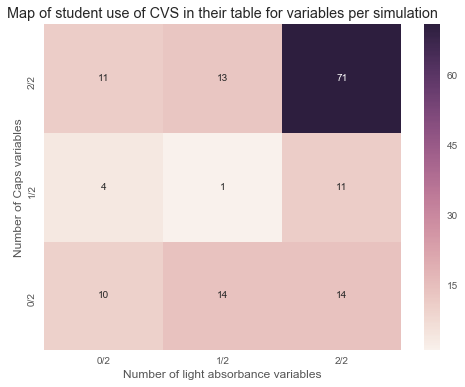

In [33]:
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum light']==j)])
ax = sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d")
ax.set_xticklabels(['0/2','1/2','2/2'])
ax.set_yticklabels(['0/2','1/2','2/2'])
plt.xlabel('Number of light absorbance variables')
plt.ylabel('Number of Caps variables')
plt.title('Map of student use of CVS in their table for variables per simulation')

High usage is consistent. If they do CVS with 1 variable in one sim, they do it with 2 in the other (probaly second sim).We'll see how order makes a difference later.

# Does using strategy help student learn?

Because CVS_table and CVS_graph are related, we need to create a CVS_table_only paramter to avoid multicollinearity in our model.

In [34]:
data['CVS_table_only'] = 0
data['CVS_table_only'] = data.apply(lambda row: row['CVS_table']*(1-row['CVS_graph']), axis = 1)
data.head()

,sid,variable,pre,main,sim,CVS_table,CVS_graph,sim_index,CVS_table_only
0,10127163,Concentration,1.0,3.0,L,1,1,1,0
1,10232160,Concentration,1.0,1.0,L,1,1,1,0
2,10537160,Concentration,1.0,2.0,L,1,0,2,1
3,10375163,Concentration,0.0,2.0,L,1,0,2,1
4,10420167,Concentration,1.0,3.0,L,1,1,2,0


In [35]:
formula = 'main ~ CVS_table_only*variable + CVS_graph*variable + pre + C(sim_index)*C(sim) + C(sid)'# + pre*C(sid)+ pre*C(sim_index) + C(sid)'
model = ols(formula, data).fit()
# print model.summary()
print "Model: ",formula
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print "Anova table using type 2 errors"
print(aov_table)

Model:  main ~ CVS_table_only*variable + CVS_graph*variable + pre + C(sim_index)*C(sim) + C(sid)
Anova table using type 2 errors
                          sum_sq     df       F     PR(>F)  eta_sq   omega_sq
variable                   2.349    3.0   2.816  3.883e-02   0.009  5.661e-03
C(sim_index)               3.686    1.0  13.259  3.042e-04   0.014  1.274e-02
C(sim)                     0.588    1.0   2.116  1.465e-01   0.002  1.159e-03
C(sid)                   132.951  147.0   3.253  2.318e-21   0.497  3.441e-01
C(sim_index):C(sim)        0.986    1.0   3.546  6.036e-02   0.004  2.645e-03
CVS_table_only             0.313    1.0   1.125  2.894e-01   0.001  1.301e-04
CVS_table_only:variable    0.287    3.0   0.344  7.936e-01   0.001 -2.045e-03
CVS_graph                  4.282    1.0  15.404  1.010e-04   0.016  1.496e-02
CVS_graph:variable         1.358    3.0   1.628  1.821e-01   0.005  1.958e-03
pre                        0.690    1.0   2.481  1.160e-01   0.003  1.539e-03
Residual     

Variable matters (will need to investigate). Order\*sim matter, but not sim alone. CVS table doesn't matter but graph does (F=15.404  p=1.010e-04   eta=0.016)! ANd it doesn't depend on the variable!

# Is there leaning of CVS?

## Consistency over time: proficient users of strategy are consistent, less proficient are less consistent

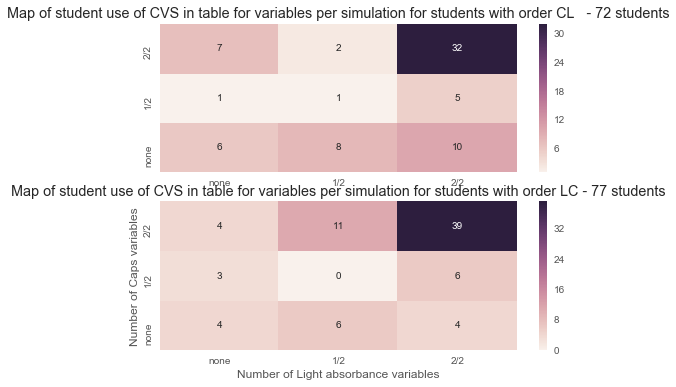

In [36]:
f, (ax1, ax2) = plt.subplots(2)
ax = ax1
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum light']==j)&(table_cvs_df2['activity order']=='CL')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d",ax=ax1)
ax.set_xticklabels(['none','1/2','2/2'])
ax.set_yticklabels(['none','1/2','2/2'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in table for variables per simulation for students with order CL   - {0} students'.format(len(table_cvs_df2[table_cvs_df2['activity order']=='CL'])))

ax = ax2
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum light']==j)&(table_cvs_df2['activity order']=='LC')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d", ax=ax2)
ax.set_xticklabels(['none','1/2','2/2'])
ax.set_yticklabels(['none','1/2','2/2'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in table for variables per simulation for students with order LC - {0} students'.format(len(table_cvs_df2[table_cvs_df2['activity order']=='LC'])))

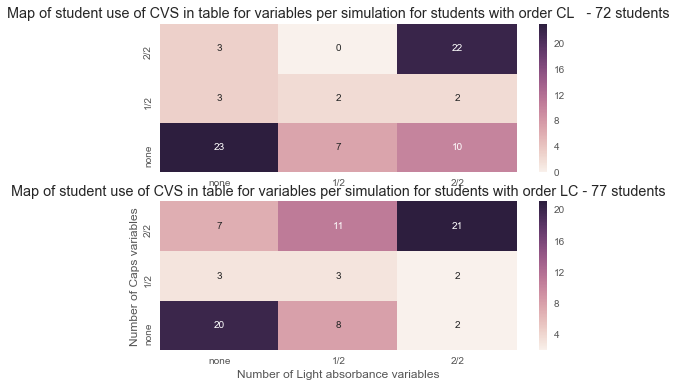

In [37]:
f, (ax1, ax2) = plt.subplots(2)
ax = ax1
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(graph_cvs_df2[(graph_cvs_df2['sum caps']==i)&(graph_cvs_df2['sum light']==j)&(graph_cvs_df2['activity order']=='CL')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d",ax=ax1)
ax.set_xticklabels(['none','1/2','2/2'])
ax.set_yticklabels(['none','1/2','2/2'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in table for variables per simulation for students with order CL   - {0} students'.format(len(graph_cvs_df2[graph_cvs_df2['activity order']=='CL'])))

ax = ax2
cvs_sim = np.zeros((3,3),dtype=int)
for i in range(3):
    for j in range(3):
        cvs_sim[i,j] = len(graph_cvs_df2[(graph_cvs_df2['sum caps']==i)&(graph_cvs_df2['sum light']==j)&(graph_cvs_df2['activity order']=='LC')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d", ax=ax2)
ax.set_xticklabels(['none','1/2','2/2'])
ax.set_yticklabels(['none','1/2','2/2'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in table for variables per simulation for students with order LC - {0} students'.format(len(graph_cvs_df2[graph_cvs_df2['activity order']=='LC'])))

High usage and no usage (in graph) is consistent. More likely to do CVS in second sim

## Can we predict use of CVS?

## Use of CVS in table vs. graph over time